# Overall Concept of Depression Dataset Structure

```
[root directory]
 │ 
 ├──[sessions/participant folder]
 ├── 300_p
 ├── ...
 ├── 492_p
 ├── csv files
 ├── ...
 │
 ├──────[all attributes of Participant]
 ├────── xxx_CLNF_features3D.txt
 ├────── xxx_CLNF_gaze.txt
 ├────── xxx_AUDIO.wav
 ├────── xxx_TRANSCRIPT.csv
 ├────── ...
 │
[class DepressionDataset]
 │
 ├──[ __init__ ]
 │  ↓ run through layer of hierarchy to get
 │    the desired sessions and ground truth
 │
 ├── train_split_Depression_AVEC2017.csv
 ├── train_split_Depression_AVEC2017.csv
 ├── full_test_split.csv
 ├── ...
 │
 ├──────[ __getitem__ ]
 │      ↓ run through layer of hierarchy
 │        to load the attributes of participant
 │
 ├────── facial landmarks
 ├────── gaze direction
 ├────── audio
 ├────── text
 └────── ...
 

```

In [1]:
from __future__ import print_function, division
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import IPython.display as ipd
from sentence_transformers import SentenceTransformer

import seaborn as sns
from skimage import io, transform
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# from ipywidgets import interact, interactive, fixed, interact_manual
# import ipywidgets as widgets
# import seaborn as sns

In [126]:
class DepressionDataset(Dataset):
    '''create a training, develop, or test dataset
       and load the participant features if it's called 
    '''
    def __init__(self,
                 root_dir,
                 mode,
                 transform=None):
        super(DepressionDataset, self).__init__()
        
        # only train, develop, test dataset allow
        assert mode in ["train", "dev", "test"],\
            "Argument --mode could only be ['train', 'dev', 'test']"
        
        self.mode = mode
        self.root_dir = root_dir
        self.transform = transform
        self.train_data_path = os.path.join(self.root_dir, 'train_split_Depression_AVEC2017.csv')
        self.dev_data_path = os.path.join(self.root_dir, 'dev_split_Depression_AVEC2017.csv')
        self.test_data_path = os.path.join(self.root_dir, 'full_test_split.csv')
        # load sent2vec model for converting text file to 2D array
        self.sent2vec = SentenceTransformer('all-mpnet-base-v2')
        
        # load training data # 107 sessions
        if self.mode == "train":
            # pre-checking and cleaning the data
            self.data_df = self.pre_check(pd.read_csv(self.train_data_path))
            # store ground truth
#             self.patientIDs = self.data_df['Participant_ID'].to_numpy()
            self.patientIDs = np.array([303,321,362,363,426]) # for debugging
            self.phq_binay_gt = self.data_df['PHQ8_Binary'].to_numpy()
            self.phq_score_gt = self.data_df['PHQ8_Score'].to_numpy()
            self.gender_gt = self.data_df['Gender'].to_numpy()
            self.phq_subscores_gt = self.data_df.iloc[:, 4:].to_numpy()
        
        # load development data # 35 sessions
        if self.mode == "dev":
            # pre-checking and cleaning the data
            self.data_df = self.pre_check(pd.read_csv(self.dev_data_path))
            # store ground truth
            self.patientIDs = self.data_df['Participant_ID'].to_numpy()
            self.phq_binay_gt = self.data_df['PHQ8_Binary'].to_numpy()
            self.phq_score_gt = self.data_df['PHQ8_Score'].to_numpy()
            self.gender_gt = self.data_df['Gender'].to_numpy()
            self.phq_subscores_gt = self.data_df.iloc[:, 4:].to_numpy()
        
        # load test data # 47 sessions
        if self.mode == "test":
            # pre-checking and cleaning the data
            self.data_df = self.pre_check(pd.read_csv(self.test_data_path))
            # store ground truth
            self.patientIDs = self.data_df['Participant_ID'].to_numpy()
            self.phq_binay_gt = self.data_df['PHQ_Binary'].to_numpy()
            self.phq_score_gt = self.data_df['PHQ_Score'].to_numpy()
            self.gender_gt = self.data_df['Gender'].to_numpy()
    
    
    def pre_check(self, data):
        '''
        Basic cleaning process to make sure no missing value
        and that the sum of each PHQ subscore equals to PHQ score 
        Argument:
            data: numpy array
        Return:
            data: numpy array with type "int"
        '''
        # make sure no NaN, Inf, -Inf
        if data.isin([np.nan, np.inf, -np.inf]).any(1).sum():
            print('Replacing NaN, Inf, or -Inf ...')
            data = data.replace([np.inf, -np.inf, np.nan], 0).astype('int')
        else: 
            data = data.astype('int')
            
        # compare the sum of each PHQ subscore to PHQ score
        unequal = data.iloc[:, 4:].sum(axis=1) != data.iloc[:,2]
        if unequal.any() and self.mode != 'test':
            lines = np.where(unequal)
            raise ValueError(("The sum of each PHQ subscore at line {} "
                              "is unequal to the PHQ score").format(lines[0]))
        
        return data
    
    
    def __len__(self):
        return len(self.patientIDs)
    
    
    def __iter__(self):
        return iter(self.patientIDs)
    
    
    def __getitem__(self, idx):
        '''
        Essentional function for creating dataset in PyTorch, which will automatically be
        called in Dataloader and load all the extracted features of the patient in the Batch
        based on the index of self.patientIDs
        Argument:
            idx: int, index of the patient ID in self.patientIDs
        Return:
            session: dict, contains all the extracted features and ground truth of a patient/session 
        '''
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # get the patient session path
        session_num = self.patientIDs[idx]
        session_path = os.path.join(self.root_dir, '{}_P'.format(session_num))
        
        # TODO: if other feature is needed, add more in the following part...
        
        # get all features path of the session
        facial_landmarks_path = os.path.join(session_path, '{}_CLNF_features3D.txt'.format(session_num))
        gaze_direction_path = os.path.join(session_path, '{}_CLNF_gaze.txt'.format(session_num))
        audio_path = os.path.join(session_path, '{}_AUDIO.wav'.format(session_num))
        text_path = os.path.join(session_path, '{}_TRANSCRIPT.csv'.format(session_num))
        
        # facial feature
        facial_landmarks = self.load_facial_landmarks(facial_landmarks_path)
        # gaze direction feature
        gaze_direction = pd.read_csv(gaze_direction_path).iloc[:, 4:].to_numpy()
        # audion feature, but constrain the rows based to match the shape of landmarks/gaze_sample
        audio, self.audio_parameters = self.load_audio(audio_path)
        audio = audio[:facial_landmarks.shape[0]]
        # text feature
        text_feature = self.load_sent2vec(text_path)
        sentence_embedding = text_feature['sentence_embeddings']
        self.sentences = text_feature['sentences']
        
        # summary
        session = {'patientID': session_num,
                   'session_path': session_path,
                   'facial_landmarks': facial_landmarks,
                   'gaze_direction': gaze_direction, 
                   'audio': audio,
                   'sentence_embeddings': sentence_embedding, 
                   'phq_score_gt': self.phq_score_gt[idx], 
                   'phq_binay_gt': self.phq_binay_gt[idx],
                   'gender_gt': self.gender_gt[idx]}
        
        if self.transform:
            session = self.transform(session)
        
        # reshape the facial landmarks to match the input requirement of ST-GCN
        frames_num, xyz_points_num = session['facial_landmarks'].size()  # exp. (58989, 204)
        # 68 keypoints
        reshaped = torch.reshape(session['facial_landmarks'], (frames_num, 3, 68, 1))
        session['facial_landmarks'] = reshaped.permute(1,0,2,3)  # .contiguous()
        
        return session
    
    
    def minmax_scaler(self, data):
        '''recale the data, which is a 2D matrix, to 0-1'''
        return (data - data.min(axis=1)[:,np.newaxis])/(data.max(axis=1) - data.min(axis=1))[:, np.newaxis]
    
    
    def load_facial_landmarks(self, facial_landmarks_path, preprocess=True):
        ''' 
        load the facial landmarks and separately recale 
        each x, y, z coordiante of each frame
        Arguments:
            facial_landmarks_path: string, absolute path to 3D facial landmarks file
            preprocess: boolean, whether normalize the data
        Return:
            landmarks: 2D numpy.ndarray, coordinate (x,y,z) of 68 3D facial points
        '''
        # load the landmarks file
        landmarks = pd.read_csv(facial_landmarks_path).iloc[:, 4:].to_numpy()
        
        if preprocess:
            # recale x, y, z
            landmarks_x = self.minmax_scaler(landmarks[:, 0:68])
            landmarks_y = self.minmax_scaler(landmarks[:, 68:136])
            landmarks_z = self.minmax_scaler(landmarks[:, 136:204])
            # concatenate together
            landmarks = np.concatenate([landmarks_x, landmarks_y, landmarks_z], axis=1)
        
        return landmarks
    
    
    def load_audio(self, audio_path, 
                   spectro_type='mel_spectrogram', 
                   frame_size = 2048,
                   hop_size = 533,
                   sample_rate = 16000,
                   num_mel_bands = 64,
                   preprocess=True):
        '''
        Standard method of loading audio and extracting audio features
        with Short-Time Fourier Transform by utilizing librosa library
        Arguments:
            audio_path: string, absolute path to audio file
            preprocess: boolean, whether normalize the data
        Return:
            audio_feature: 2D numpy.ndarray, extracted audio feature (spectra) in dB
        '''
        # only spectrogram and mel_spectrogram are allow
        assert spectro_type in ['spectrogram', 'mel_spectrogram'],\
            "Argument --spectro could only be ['spectrogram', 'mel_spectrogram']"
        
        # parameter setting for Short-Time Fourier Transform
        audio_parameters = {'spectro_type': spectro_type,
                            'sample_rate': sample_rate,
                            'frame_size': frame_size,
                            'hop_size': hop_size, 
                            'num_mel_bands': num_mel_bands}
        
        # load audio file with librosa
        sampled_values, sr = librosa.load(audio_path, sr=audio_parameters['sample_rate'])  
        ''' According to documnet sample rate is 16kHz
            sampled_values: audio sampled values of time series
            sr: sampling rate of audio
        '''
        
        # extracting features
        if spectro_type == 'spectrogram':
            # use Short-Time Fourier Transform, return complex-valued matrix STFT coefficients
            extracted_values = librosa.stft(sampled_values, 
                                            n_fft=audio_parameters['frame_size'], 
                                            hop_length=audio_parameters['hop_size'])
            # calculating the spectrogram
            extracted_values = np.abs(extracted_values) ** 2
            # print("Shape of the extracted features in dB: {}".format(extracted_values.shape))   
        elif spectro_type == 'mel_spectrogram':
            # get the Mel filter banks
            self.filter_banks = librosa.filters.mel(n_fft=audio_parameters['frame_size'], 
                                                    sr=audio_parameters['sample_rate'], 
                                                    n_mels=audio_parameters['num_mel_bands'])
            # extract the mel spectrograom
            extracted_values = librosa.feature.melspectrogram(sampled_values, 
                                                              sr=audio_parameters['sample_rate'], 
                                                              n_fft=audio_parameters['frame_size'], 
                                                              hop_length=audio_parameters['hop_size'], 
                                                              n_mels=audio_parameters['num_mel_bands'])
            # print("Shape of the extracted_values in dB: {}".format(extracted_values.shape))
        else:
            raise ValueError("The given value of spectro_type is not supported\n"
                             "'spectro_type' could only be 'spectrogram' or 'mel_spectrogram'")
        
        # convert amplitude to DBs
        # transpose the result so that the rows corresponds to time and column to frequence
        audio_feature = np.transpose(librosa.power_to_db(extracted_values))
#         print("Shape of the final extracted audio feature (spectra) in dB: {}".format(audio_feature.shape))
        
        if preprocess:
            audio_feature = self.minmax_scaler(audio_feature)
            
        return audio_feature, audio_parameters
    
    
    def load_sent2vec(self, text_path, speaker='Participant'):
        '''
        Standard method of loading audio and extracting audio features
        with Short-Time Fourier Transform by utilizing librosa library
        Arguments:
            text_path: string, absolute path to transcipt file
            speaker: certain string, which transcript of the speaker to load
        Return:
            text_feature: dict, contain converted embedding vectors, sentences, etc.
        '''
        
        # only 'Ellie', 'Participant', 'both' are allow
        assert speaker in ['Ellie', 'Participant', 'both'],\
            "Argument --speaker could only be ['Ellie', 'Participant', 'both']"
        
        text_file = pd.read_csv(text_path)
        # tokenize the text file, filter out all \t space and unnecessary columns such as time, participent 
        tokenized_words = self.tokenize_corpus(text_file.values.tolist()[i][0] for i in range(text_file.shape[0]))
        
        sentences = []
        sentences_idx = []
        
        if speaker == 'Ellie':
            for idx, sentence in enumerate(tokenized_words):
                if sentence[2] == 'Ellie':
                    sentences.append(sentence[3:])
                    sentences_idx.append(idx)
        elif speaker == 'Participant':
            for idx, sentence in enumerate(tokenized_words):
                if sentence[2] == 'Participant':
                    sentences.append(sentence[3:])
                    sentences_idx.append(idx)
                    
        else: # speaker == 'both'
            sentences = [tokenized_words[i][3:] for i in range(len(tokenized_words))]
            sentences_idx = list(range(len(tokenized_words)))
    
        # recombine 2D list of words into 1D list of sentence
        final_sentences = [" ".join(sentences[i]).lower() for i in range(len(sentences))]
        # convert sentence to vector with SentenceTransformer pretrained model
        sentence_embeddings = self.sent2vec.encode(final_sentences)
        
        # summary
        text_feature = {'speaker': speaker,
                        'sentence_embeddings': sentence_embeddings,
                        'sentences': final_sentences, 
                        'indices': sentences_idx}
        
        return text_feature
     
        
    def tokenize_corpus(self, corpus):
        '''tokenzie a given list of string into list of words
        Argument:
            corpus: 1D list of string, each element is a sting of sentence
        Return:
            tokens: 2D list of string, each raw is a list of words splitted from sentence 
        '''
        tokens = [x.split() for x in corpus]
        return tokens
    
    
    def cosine_similarity(self, u, v):
        '''Calculate the similarity between 1D arrays'''
        return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))
    
    
    def similarity_matrix(self, array):
        '''Calculate the similarity matrix by given a 2D array'''
        shape = array.shape
        similarity = np.zeros((shape[0],shape[0]))

        for i in range(shape[0]):
            for k in range(shape[0]):
                similarity[i][k] = self.cosine_similarity(array[i], array[k])

        return similarity
        
    
    def show_landmarks_gaze(self, landmarks, gaze_direction, frame, gaze_factor=0.3):
        """Show image with landmarks for a batch of samples.
        Arguments:
            landmarks_gaze: dict, could be one or more sessions, should
                            contain 'facial_landmarks' & 'gaze_direction' array
            frame: int, index of the desired frame to show
            gaze_factor: float, length of the gaze vector
        Return:
            plot the image with 68 landmarks + gaze direction
            of both eyes for visualization
        """

        # get x, y, z coordinate of landmarks of a frame
        x_3D = landmarks[frame, 0: 68]
        y_3D = landmarks[frame, 68: 136]
        z_3D = landmarks[frame, 136: 204]

        # get gaze direction vector of a frame
        gx_l, gy_l, gz_l, gx_r, gy_r, gz_r = gaze_direction[frame, :6]
        gxh_l, gyh_l, gzh_l, gxh_r, gyh_r, gzh_r = gaze_direction[frame, 6:]

        # calculate the middle point of each eye
        left_eye_x = (x_3D[37] + x_3D[38] + x_3D[40] + x_3D[41])/4
        left_eye_y = (y_3D[37] + y_3D[38] + y_3D[40] + y_3D[41])/4
        left_eye_z = (z_3D[37] + z_3D[38] + z_3D[40] + z_3D[41])/4
        right_eye_x = (x_3D[43] + x_3D[44] + x_3D[46] + x_3D[47])/4
        right_eye_y = (y_3D[43] + y_3D[44] + y_3D[46] + y_3D[47])/4
        right_eye_z = (z_3D[43] + z_3D[44] + z_3D[46] + z_3D[47])/4

        # plot figure
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(x_3D,y_3D,z_3D)
        # plot gaze direction in world coordinate
        ax.plot([left_eye_x, left_eye_x+gx_l*gaze_factor], 
                [left_eye_y, left_eye_y+gy_l*gaze_factor], 
                [left_eye_z, left_eye_z+gz_l*gaze_factor], 
                'r-', label='Gaze direction in world coordinate')
        ax.plot([right_eye_x, right_eye_x+gx_r*gaze_factor], 
                [right_eye_y, right_eye_y+gy_r*gaze_factor], 
                [right_eye_z, right_eye_z+gz_r*gaze_factor], 
                'r-')
        # plot gaze direction in head coordinate
        ax.plot([left_eye_x, left_eye_x+gxh_l*gaze_factor], 
                [left_eye_y, left_eye_y+gyh_l*gaze_factor], 
                [left_eye_z, left_eye_z+gzh_l*gaze_factor], 
                'g-', label='Gaze direction in head coordinate')
        ax.plot([right_eye_x, right_eye_x+gxh_r*gaze_factor], 
                [right_eye_y, right_eye_y+gyh_r*gaze_factor], 
                [right_eye_z, right_eye_z+gzh_r*gaze_factor], 
                'g-')
        # plot set up
        ax.view_init(elev = -80, azim = -90)
        ax.set_title('68 3D Facial Keypoints of Patient')
        ax.legend(loc = 'lower center')
        ax.set_xlabel("x coordinate") 
        ax.set_ylabel("y coordinate")
        ax.set_zlabel("z coordinate")
        plt.tight_layout()
        plt.show()

        
    def show_spectrogram(self, audio_feature, audio_parameters, y_axis="log"):
        """Show spectrogram for a batch of samples.
        Arguments:
            audio_feature: 2D numpy.ndarray, extracted audio feature (spectra) in dB
            audio_parameters: dict, all parameters setting of STFT 
                              we used for feature extraction
            y_axis: certain string, scale of the y axis. could be 'linear' or 'log'
        Return:
            plot the spectrogram
        """
        
        # transpose, so the column corresponds to time series
        audio_feature = np.transpose(audio_feature)
        
        plt.figure(figsize=(25, 10))
        im = librosa.display.specshow(audio_feature, 
                                      sr=audio_parameters['sample_rate'], 
                                      hop_length=audio_parameters['hop_size'], 
                                      x_axis="time", 
                                      y_axis=y_axis)
        plt.colorbar(format="%+2.f dB")
        return im
    
    
    def show_mel_filter_banks(self, filter_banks, audio_parameters):
        """Show Mel filter bank for a batch of samples.
        Arguments:
            filter_banks: 2D numpy.ndarray, please use self.filter_banks to get the value, 
                          but make sure load_audio(spectro_type='mel_spectrogram') is called
            audio_parameters: dict, all parameters setting of STFT 
                                    we used for feature extraction
        Return:
            visualize the mel filter banks
        """
        plt.figure(figsize=(25, 10))
        im = librosa.display.specshow(filter_banks,
                                      sr=audio_parameters['sample_rate'], 
                                      x_axis="linear")
        plt.colorbar(format="%+2.f")
        return im
    
    def show_text_correlation(self, text_feature, start_sent, sent_len):
        """Show the correlation between each sentence.
        Arguments:
            text_feature: 2D numpy.ndarray, converted sentence embedding vectors
            start_sent: int, start index of the sentence you want
            sent_len: int, number of sentence you want to compare 
                      (size of correlation matrix)
        Return:
            plot the correlation matrix between sentences
        """
        # calculate correlation matrix
        correlation = np.corrcoef(text_feature['sentence_embeddings'][int(start_sent):int(start_sent+sent_len)])
        plt.figure(figsize=(12,12))
        # plot heatmap
        heatmap = sns.heatmap(correlation, annot=True,  fmt='.2g')  # cbar_kws={'label': 'correlation'}
        # set scale label
        heatmap.set_xticklabels(text_feature['indices'][int(start_sent):int(start_sent+sent_len)]) # rotation=-30
        heatmap.set_yticklabels(text_feature['indices'][int(start_sent):int(start_sent+sent_len)], rotation=0)
        # set label
        plt.xlabel("sentence number in conversation")
        plt.ylabel("sentence number in conversation") 
        plt.show()
    
    
    def show_similarity_matrix(self, text_feature, start_sent, sent_len):
        '''plot the result of similarity matrix as heatmap'''
        # calculate similarity
        similarity = self.similarity_matrix(text_feature['sentence_embeddings'][int(start_sent):int(start_sent+sent_len)])
        # plot heatmap
        plt.figure(figsize=(16,16))
        heatmap = sns.heatmap(similarity, annot=True,  fmt='.2g')  # cbar_kws={'label': 'correlation'}
        # set scale label
        heatmap.set_xticklabels(text_feature['indices'][int(start_sent):int(start_sent+sent_len)]) # rotation=-30
        heatmap.set_yticklabels(text_feature['indices'][int(start_sent):int(start_sent+sent_len)], rotation=0)
        # set label
        plt.xlabel("sentence number in conversation")
        plt.ylabel("sentence number in conversation")
        plt.show()
    
    
    def find_max_length(self):
        '''find out the maximum lenghth of each features among all patients'''
    
        # initialize each value
        max_length = {'landmarks': 0, 
                      'gaze_samples': 0, 
                      'text': 0}

        for name in os.listdir(self.root_dir):
            name_path = os.path.join(self.root_dir, name)
            if os.path.isdir(name_path) and name.endswith('_P'):
                session = name.split('_')[0]
                print('searching through patient {} ...'.format(session))

                facial_landmarks_path = os.path.join(name_path, '{}_CLNF_features3D.txt'.format(session))
                gaze_direction_path = os.path.join(name_path, '{}_CLNF_gaze.txt'.format(session))
                text_path = os.path.join(name_path, '{}_TRANSCRIPT.csv'.format(session))

                facial_landmarks = pd.read_csv(facial_landmarks_path)
                if len(facial_landmarks) > max_length['landmarks']:
                    max_length['landmarks'] = len(facial_landmarks)

                gaze_direction = pd.read_csv(gaze_direction_path)
                if len(gaze_direction) > max_length['gaze_samples']:
                    max_length['gaze_samples'] = len(gaze_direction)

                text_feature = self.load_sent2vec(text_path, speaker='Participant')
                if text_feature['sentence_embeddings'].shape[0] > max_length['text']:
                    max_length['text'] = text_feature['sentence_embeddings'].shape[0]

        if max_length['gaze_samples'] != max_length['landmarks']:
            max_length['gaze_samples'] = max_length['landmarks']
    
        return max_length

In [62]:
class Padding(object):
    ''' pad zero to each feature matrix so that they all have the same size '''
    def __init__(self, 
                 landmarks_output_size=(58989, 204), 
                 gaze_output_size=(58989, 12), 
                 audio_output_size=(58989, 64), 
                 text_output_size=(386, 768)):
        '''
        Each output size could be 'int' or 'tuple'. 
        Integer would be the number of desired rows
        and Tuple would be the desired 2D array size.
        
        Here is recommended to keep the number of columns 
        as they are and only set the number of rows with int
        
        To find the maximum length of rows, please use the 
        'find_max_length' function in DepressionDataset class 
        to search through. 
        
        The value 58989 & 389 are the maximum length in our case.
        '''
        
        assert isinstance(landmarks_output_size, (int, tuple))
        assert isinstance(gaze_output_size, (int, tuple))
        assert isinstance(audio_output_size, (int, tuple))
        assert isinstance(text_output_size, (int, tuple))
        
        self.landmarks_output_size = landmarks_output_size
        self.gaze_output_size = gaze_output_size
        self.audio_output_size = audio_output_size
        self.text_output_size = text_output_size
    
    
    def __call__(self, session):
        facial_landmarks = session['facial_landmarks']
        gaze_direction = session['gaze_direction']
        audio = session['audio']
        sentence_embeddings = session['sentence_embeddings']
        
        # facial landmarks padding
        if isinstance(self.landmarks_output_size, int):
            shape = facial_landmarks.shape
            assert self.landmarks_output_size >= shape[0],\
                "landmarks output size should be bigger than {}".format(shape[0])
            padded_landmarks = np.zeros((self.landmarks_output_size, shape[1]))
            padded_landmarks[:shape[0],:shape[1]] = facial_landmarks
        else:
            shape = facial_landmarks.shape
            assert self.landmarks_output_size[0] >= shape[0] and self.landmarks_output_size[1] >= shape[1],\
                "landmarks output size should be bigger than {}".format(shape)
            padded_landmarks = np.zeros(self.landmarks_output_size)
            padded_landmarks[:shape[0],:shape[1]] = facial_landmarks
            
        # gaze direction padding
        if isinstance(self.gaze_output_size, int):
            shape = gaze_direction.shape
            assert self.gaze_output_size >= shape[0],\
                "gaze output size should be bigger than {}".format(shape[0])
            padded_gaze = np.zeros((self.gaze_output_size, shape[1]))
            padded_gaze[:shape[0],:shape[1]] = gaze_direction
        else:
            shape = gaze_direction.shape
            assert self.gaze_output_size[0] >= shape[0] and self.gaze_output_size[1] >= shape[1],\
                "gaze output size should be bigger than {}".format(shape)
            padded_gaze = np.zeros(self.gaze_output_size)
            padded_gaze[:shape[0],:shape[1]] = gaze_direction
            
        # audio padding
        if isinstance(self.audio_output_size, int):
            shape = audio.shape
            assert self.audio_output_size >= shape[0],\
                "audio output size should be bigger than {}".format(shape[0])
            padded_audio = np.zeros((self.audio_output_size, shape[1]))
            padded_audio[:shape[0],:shape[1]] = audio
        else:
            shape = audio.shape
            assert self.audio_output_size[0] >= shape[0] and self.audio_output_size[1] >= shape[1],\
                "audio output size should be bigger than {}".format(shape)
            padded_audio = np.zeros(self.audio_output_size)
            padded_audio[:shape[0],:shape[1]] = audio
            
        # text padding
        if isinstance(self.text_output_size, int):
            shape = sentence_embeddings.shape
            assert self.text_output_size >= shape[0],\
                "audio output size should be bigger than {}".format(shape[0])
            padded_text = np.zeros((self.text_output_size, shape[1]))
            padded_text[:shape[0],:shape[1]] = sentence_embeddings
        else:
            shape = sentence_embeddings.shape
            assert self.text_output_size[0] >= shape[0] and self.text_output_size[1] >= shape[1],\
                "audio output size should be bigger than {}".format(shape)
            padded_text = np.zeros(self.text_output_size)
            padded_text[:shape[0],:shape[1]] = sentence_embeddings
        
        # summary
        padded_session = {'patientID': session['patientID'],
                          'session_path': session['session_path'],
                          'facial_landmarks': padded_landmarks,
                          'gaze_direction': padded_gaze, 
                          'audio': padded_audio,
                          'sentence_embeddings': padded_text, 
                          'phq_score_gt': session['phq_score_gt'], 
                          'phq_binay_gt': session['phq_binay_gt'],
                          'gender_gt': session['gender_gt']}
        
        return padded_session
    
    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors or np.int to torch.tensor."""
    
    def __call__(self, session):
        facial_landmarks = session['facial_landmarks']
        gaze_direction = session['gaze_direction']
        audio = session['audio']
        sentence_embeddings = session['sentence_embeddings']
        
        converted_session = {'patientID': session['patientID'],
                             'session_path': session['session_path'],
                             'facial_landmarks': torch.from_numpy(session['facial_landmarks']),
                             'gaze_direction': torch.from_numpy(session['gaze_direction']), 
                             'audio': torch.from_numpy(session['audio']),
                             'sentence_embeddings': torch.from_numpy(session['sentence_embeddings']), 
                             'phq_score_gt': torch.tensor(session['phq_score_gt']), 
                             'phq_binay_gt': torch.tensor(session['phq_binay_gt']),
                             'gender_gt': torch.tensor(session['gender_gt'])}
        
        return converted_session
    

# Test each funtion of customized DepressionDataset

In [49]:
# create example of traning dataset
dataset_example = DepressionDataset(os.path.join(os.getcwd(), 'DAIC-WOZ Dataset'), 'train')
len(dataset_example)

5

In [50]:
# take a look of patientsIDs
dataset_example.patientIDs

array([303, 321, 362, 363, 426])

In [52]:
patient_426 = dataset_example[4]

In [53]:
print(patient_426['patientID'])
print(patient_426['gender_gt'])
print(patient_426['phq_score_gt'])

426
1
2


In [57]:
print(patient_426['facial_landmarks'].shape)
print(patient_426['gaze_direction'].shape)
print(patient_426['audio'].shape)
print(patient_426['sentence_embeddings'].shape)

(25704, 204)
(25704, 12)
(25704, 64)
(225, 768)


In [38]:
# find out the max lenghth of each features among all patients
max_length = dataset_example.find_max_length()
print('max rows of landmarks: {}'.format(max_length['landmarks']))
print('max rows of gaze direction: {}'.format(max_length['gaze_samples']))
print('max rows of sentence embeddings: {}'.format(max_length['text']))

searching through patient 300 ...
searching through patient 303 ...
searching through patient 321 ...
searching through patient 362 ...
searching through patient 363 ...
searching through patient 426 ...
max rows of landmarks: 36814
max rows of gaze direction: 36814
max rows of sentence embeddings: 225


#### Test Padding class to make sure it works

In [71]:
padding = Padding(landmarks_output_size=58989, 
                  gaze_output_size=58989, 
                  audio_output_size=58989, 
                  text_output_size=386)
# padding = Padding()
padded_patient_426 = padding(patient_426)

print(padded_patient_426['facial_landmarks'].shape)
print(padded_patient_426['gaze_direction'].shape)
print(padded_patient_426['audio'].shape)
print(padded_patient_426['sentence_embeddings'].shape)

(58989, 204)
(58989, 12)
(58989, 64)
(386, 768)


In [70]:
padded_patient_426['sentence_embeddings']

array([[-0.06686588,  0.00642519, -0.00946935, ...,  0.053578  ,
        -0.00591119, -0.00043976],
       [ 0.0420063 , -0.01610954, -0.01089271, ...,  0.00546031,
        -0.00695948,  0.00344678],
       [ 0.00499931, -0.0001819 , -0.0121916 , ..., -0.03628078,
        -0.02999774,  0.03056169],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

### Facial features, including 3D facial landmarks & gaze direction
_Goal:_
   - test "load_facial_landmarks" function
   - test "show_landmarks_gaze" function

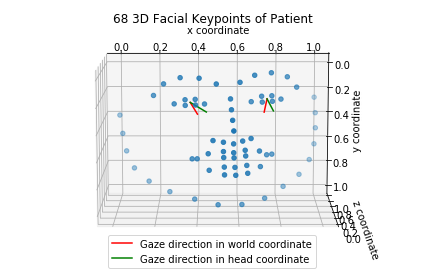

In [209]:
# get the path
facial_path = os.path.join(os.getcwd(), 'DAIC-WOZ Dataset', '303_P', '303_CLNF_features3D.txt')
gaze_path = os.path.join(os.getcwd(), 'DAIC-WOZ Dataset', '303_P', '303_CLNF_gaze.txt')

# laod the file
facial_landmarks = dataset_example.load_facial_landmarks(facial_path, preprocess=True)
gaze_direction = pd.read_csv(gaze_path).iloc[:, 4:].to_numpy()

# plot
dataset_example.show_landmarks_gaze(facial_landmarks, gaze_direction, frame=220, gaze_factor=0.3)

### Audio features, including spectrogram, mel spectrogram, and mel filter banks

_Goal:_
   - test "load_audio" function
   - test "show_spectrogram" function
   - test "show_mel_filter_banks" function

Shape of the final extracted audio feature (spectra) in dB: (29578, 1025)


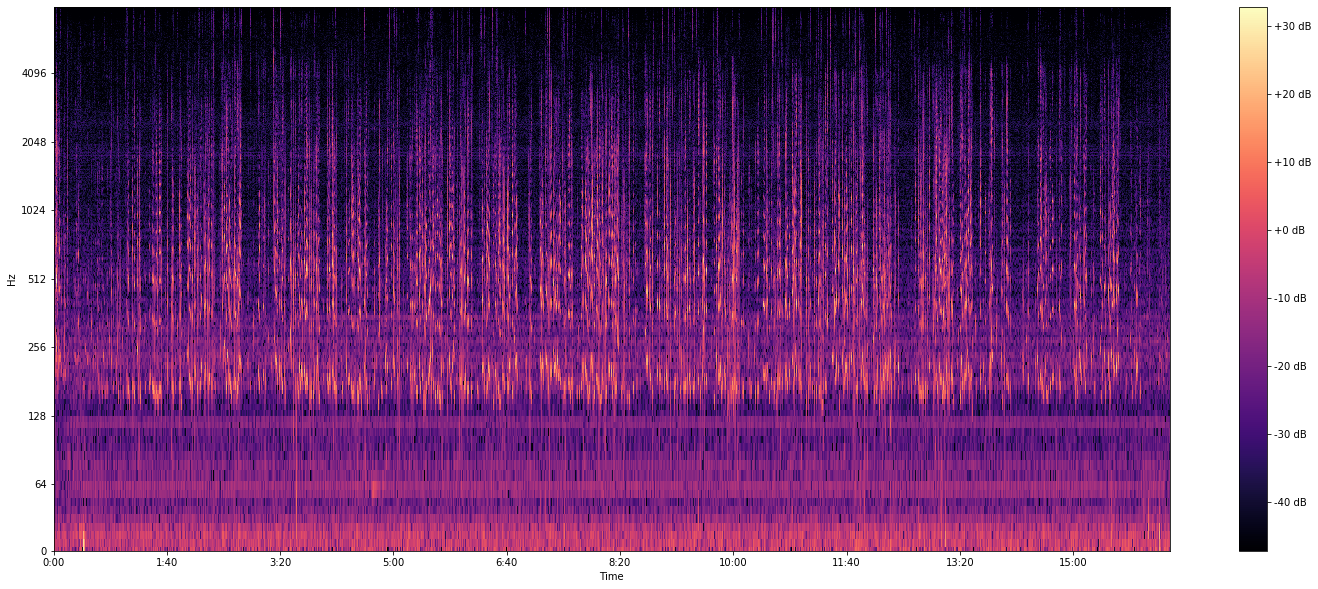

In [72]:
audio_path = os.path.join(os.getcwd(), 'DAIC-WOZ Dataset', '303_P', '303_AUDIO.wav')
audio_feature, audio_parameters = dataset_example.load_audio(audio_path, spectro_type='spectrogram', preprocess=False)
im = dataset_example.show_spectrogram(audio_feature, audio_parameters)

Shape of the final extracted audio feature (spectra) in dB: (29578, 64)


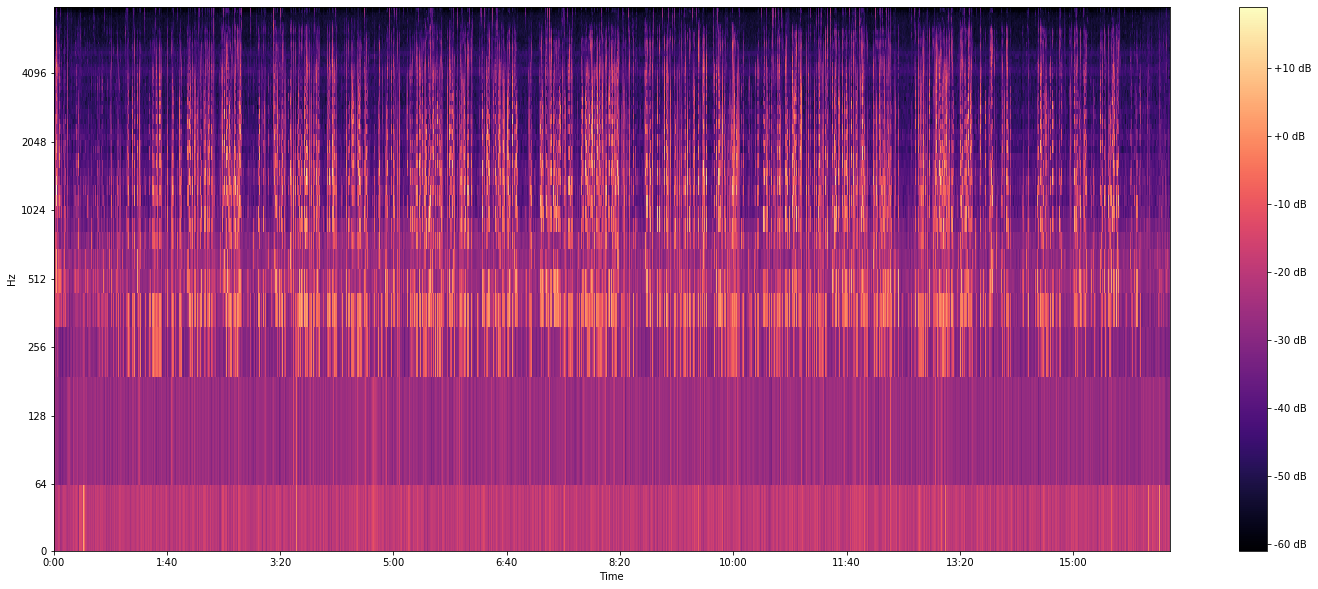

In [73]:
audio_path = os.path.join(os.getcwd(), 'DAIC-WOZ Dataset', '303_P', '303_AUDIO.wav')
audio_feature, audio_parameters = dataset_example.load_audio(audio_path, spectro_type='mel_spectrogram', preprocess=False)
im = dataset_example.show_spectrogram(audio_feature, audio_parameters)

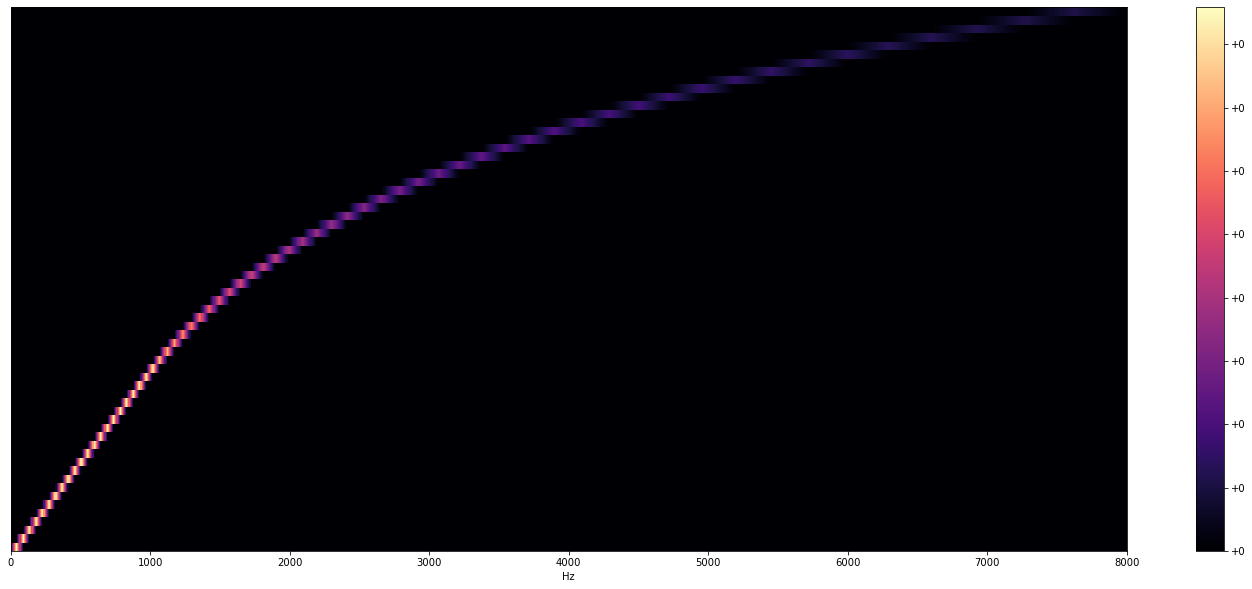

In [74]:
dataset_example.show_mel_filter_banks(dataset_example.filter_banks, audio_parameters)

### Text features, including sentence2vec and correlation

_Goal:_
   - test "load_sent2vec" function
   - test "show_text_correlation" function

In [180]:
text_path = os.path.join(os.getcwd(), 'DAIC-WOZ Dataset', '303_P', '303_TRANSCRIPT.csv')
text_feature = dataset_example.load_sent2vec(text_path, speaker='Participant')
text_feature['sentence_embeddings'].shape

(103, 768)

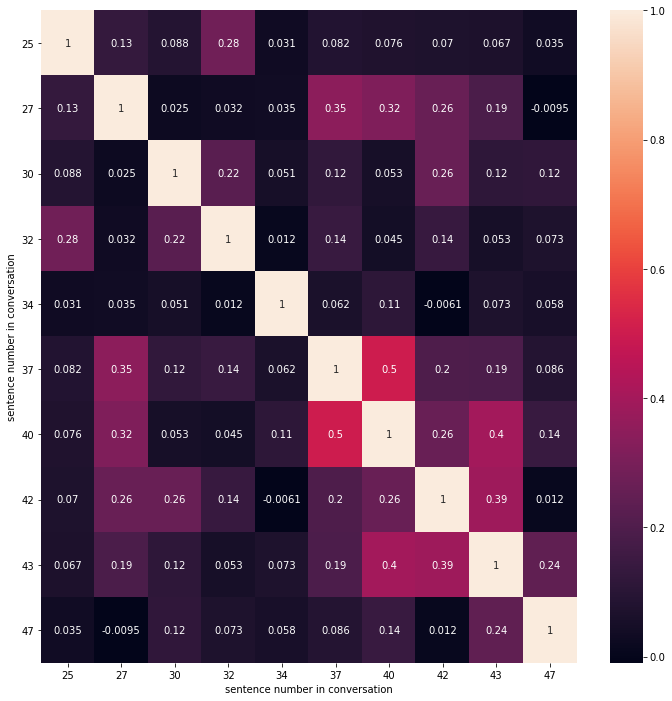

In [181]:
dataset_example.show_text_correlation(text_feature, 10, 10)

# Test "\__getitem\__ " in dataset 

In [201]:
for sesseion_idx in range(len(dataset_example)):
    session = dataset_example[sesseion_idx]
    print('Patient ID: {}'.format(session['patientID']))
    print('Frame number: {}'.format(session['frames_num']))
    print('====================')
    

303
29565
321
24658
362
17710
363
36814
426
25704


In [203]:
# patient 303
session_303 = dataset_example[0]

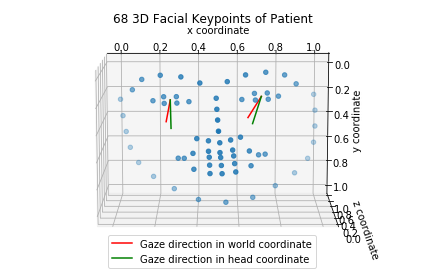

In [204]:
dataset_example.show_landmarks_gaze(session_303['facial_landmarks'],
                                    session['gaze_direction'], 
                                    frame = 189)

In [ ]:
dataset_example.show_spectrogram(session_303['audio'], dataset_example.audio_parameters)

In [ ]:
session

# Data Loader

### First, test with batch size 1 so that we could visualize

In [71]:
# create dataset
dataset = DepressionDataset(os.path.join(os.getcwd(), 'DAIC-WOZ Dataset'), 
                            'train')
# create dataloader
dataloader = DataLoader(dataset, 
                        batch_size=1,
                        shuffle=False, 
                        num_workers=0)

0 torch.Size([1, 29565, 204])


<Figure size 432x288 with 0 Axes>

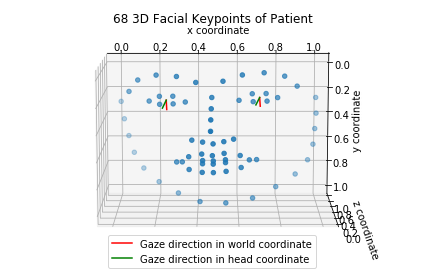

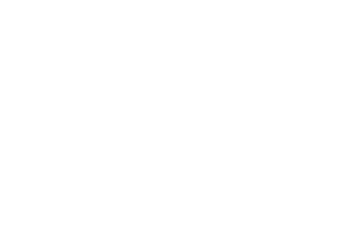

1 torch.Size([1, 24658, 204])


<Figure size 432x288 with 0 Axes>

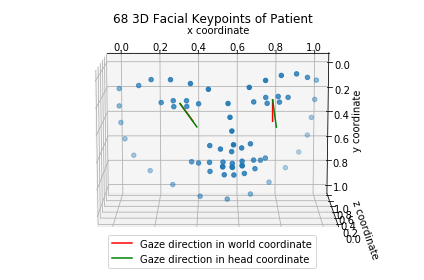

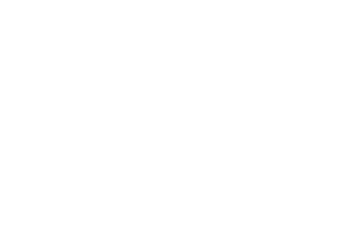

2 torch.Size([1, 17710, 204])


<Figure size 432x288 with 0 Axes>

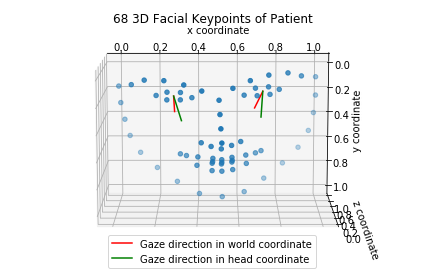

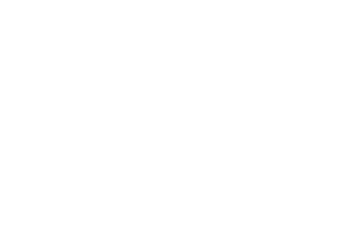

3 torch.Size([1, 36814, 204])


<Figure size 432x288 with 0 Axes>

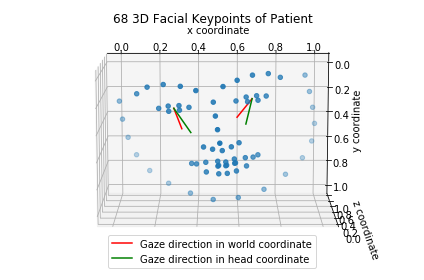

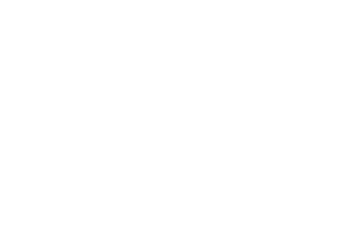

In [211]:
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['facial_landmarks'].size())
    
    # observe 1st - 4th batches and stop.
    plt.figure()
    dataset.show_landmarks_gaze(sample_batched['facial_landmarks'][0], 
                                sample_batched['gaze_direction'][0], 
                                frame=30)
    plt.axis('off')
    plt.ioff()
    plt.show()
    if i_batch == 3:
        break

### Then test with plural batches

In [127]:
torch.cuda.empty_cache()

transformed_dataset = DepressionDataset(os.path.join(os.getcwd(), 'DAIC-WOZ Dataset'), 
                                        mode='train',
                                        transform=transforms.Compose([Padding(), ToTensor()]))
# create dataloader
dataloader = DataLoader(transformed_dataset, 
                        batch_size=2,
                        shuffle=False, 
                        num_workers=0)

In [128]:
for i_batch, sample_batched in enumerate(dataloader):
    print('Batch number: ', i_batch, ', facial landmarks: ', sample_batched['facial_landmarks'].size())
    print('Batch number: ', i_batch, ', gaze vectors: ', sample_batched['gaze_direction'].size())
    print('Batch number: ', i_batch, ', audio spectrogram: ', sample_batched['audio'].size())
    print('Batch number: ', i_batch, ', sentence embeddings: ', sample_batched['sentence_embeddings'].size())
    print('=================================')
    
    if i_batch == 0:
        keypoints = sample_batched['facial_landmarks']

keypoints.size()
    

Batch number:  0 , facial landmarks:  torch.Size([2, 3, 58989, 68, 1])
Batch number:  0 , gaze vectors:  torch.Size([2, 58989, 12])
Batch number:  0 , audio spectrogram:  torch.Size([2, 58989, 64])
Batch number:  0 , sentence embeddings:  torch.Size([2, 386, 768])
Batch number:  1 , facial landmarks:  torch.Size([2, 3, 58989, 68, 1])
Batch number:  1 , gaze vectors:  torch.Size([2, 58989, 12])
Batch number:  1 , audio spectrogram:  torch.Size([2, 58989, 64])
Batch number:  1 , sentence embeddings:  torch.Size([2, 386, 768])
Batch number:  2 , facial landmarks:  torch.Size([1, 3, 58989, 68, 1])
Batch number:  2 , gaze vectors:  torch.Size([1, 58989, 12])
Batch number:  2 , audio spectrogram:  torch.Size([1, 58989, 64])
Batch number:  2 , sentence embeddings:  torch.Size([1, 386, 768])


torch.Size([2, 3, 58989, 68, 1])

# reshape the matrix to match the desired format

In [107]:
keypoints_reshaped = torch.reshape(keypoints, (2, 58989, 3, 68, 1))
keypoints_reshaped.shape

torch.Size([2, 58989, 3, 68, 1])

In [113]:
keypoints_reshaped[0][30, 0].squeeze()

tensor([0.0000, 0.0166, 0.0397, 0.0680, 0.1181, 0.1989, 0.3003, 0.4108, 0.5390,
        0.6722, 0.7907, 0.8920, 0.9568, 0.9842, 0.9929, 1.0000, 0.9989, 0.0555,
        0.1026, 0.1965, 0.2982, 0.3928, 0.5243, 0.6183, 0.7252, 0.8277, 0.8920,
        0.4703, 0.4678, 0.4658, 0.4649, 0.3739, 0.4262, 0.4766, 0.5282, 0.5753,
        0.1595, 0.2116, 0.2783, 0.3398, 0.2799, 0.2130, 0.6033, 0.6681, 0.7362,
        0.7939, 0.7406, 0.6726, 0.2976, 0.3587, 0.4221, 0.4731, 0.5295, 0.6073,
        0.6891, 0.6123, 0.5391, 0.4781, 0.4243, 0.3605, 0.3257, 0.4263, 0.4777,
        0.5361, 0.6532, 0.5364, 0.4772, 0.4258], dtype=torch.float64)

In [116]:
keypoints_input = keypoints_reshaped.permute(0,2,1,3,4).contiguous()

keypoints_input.shape

torch.Size([2, 3, 58989, 68, 1])

In [117]:
def show(landmarks, frame):

    # get x, y, z coordinate of landmarks of a frame
    x_3D = landmarks[0, frame].squeeze()
    y_3D = landmarks[1, frame].squeeze()
    z_3D = landmarks[2, frame].squeeze()

    # plot figure
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x_3D,y_3D,z_3D)
    
    # plot set up
    ax.view_init(elev = -80, azim = -90)
    ax.set_title('68 3D Facial Keypoints of Patient')
#     ax.legend(loc = 'lower center')
    ax.set_xlabel("x coordinate") 
    ax.set_ylabel("y coordinate")
    ax.set_zlabel("z coordinate")
    plt.tight_layout()
    plt.show()

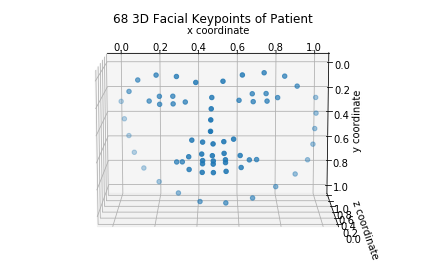

In [130]:
show(keypoints_input[0], 30)

In [87]:
x = np.array([[[0], [1], [2]]])
print(x.shape)

x.squeeze(0)

(1, 3, 1)


array([[0],
       [1],
       [2]])

In [124]:
a = torch.tensor(np.arange(16).reshape(2,1,2,4))
h, v, w = a.squeeze().size()


2

In [11]:
a.transpose(0, 2)

tensor([[[ 0,  8],
         [ 4, 12]],

        [[ 1,  9],
         [ 5, 13]],

        [[ 2, 10],
         [ 6, 14]],

        [[ 3, 11],
         [ 7, 15]]], dtype=torch.int32)

In [35]:
import random 
list_torch = [torch.tensor([random.sample(range(0, 10), 5)]),
              torch.tensor([[0.045, 0.0489, 0.59, 0.08, 0.63]]),
              torch.tensor([random.sample(range(0, 10), 5)])]
list_torch

[tensor([[5, 0, 9, 7, 6]]),
 tensor([[0.0450, 0.0489, 0.5900, 0.0800, 0.6300]]),
 tensor([[3, 1, 2, 6, 0]])]

# Debug AS-GCN

In [46]:
class Graph():

    def __init__(self,
                 layout='openpose',
                 strategy='uniform',
                 max_hop=2,
                 dilation=1):
        self.max_hop = max_hop
        self.dilation = dilation

        self.get_edge(layout)
        self.hop_dis = get_hop_distance(self.num_node, self.edge, max_hop=max_hop)
        self.get_adjacency(strategy)

    def __str__(self):
        return self.A

    def get_edge(self, layout):
        if layout == 'openpose':
            self.num_node = 18
            self_link = [(i, i) for i in range(self.num_node)]
            neighbor_link = [(4, 3), (3, 2), (7, 6), (6, 5), (13, 12), (12, 11),
                             (10, 9), (9, 8), (11, 5), (8, 2), (5, 1), (2, 1),
                             (0, 1), (15, 0), (14, 0), (17, 15), (16, 14)]
            self.edge = self_link + neighbor_link
            self.center = 1
        elif layout == 'ntu-rgb+d':
            self.num_node = 25
            self_link = [(i, i) for i in range(self.num_node)]
            neighbor_1base = [(1, 2), (2, 21), (3, 21), (4, 3), (5, 21),
                              (6, 5), (7, 6), (8, 7), (9, 21), (10, 9),
                              (11, 10), (12, 11), (13, 1), (14, 13), (15, 14),
                              (16, 15), (17, 1), (18, 17), (19, 18), (20, 19),
                              (22, 23), (23, 8), (24, 25), (25, 12)]
            neighbor_link = [(i - 1, j - 1) for (i, j) in neighbor_1base]
            self.edge = self_link + neighbor_link
            self.center = 21 - 1
        elif layout == 'ntu_edge':
            self.num_node = 24
            self_link = [(i, i) for i in range(self.num_node)]
            neighbor_1base = [(1, 2), (3, 2), (4, 3), (5, 2), (6, 5), (7, 6),
                              (8, 7), (9, 2), (10, 9), (11, 10), (12, 11),
                              (13, 1), (14, 13), (15, 14), (16, 15), (17, 1),
                              (18, 17), (19, 18), (20, 19), (21, 22), (22, 8),
                              (23, 24), (24, 12)]
            neighbor_link = [(i - 1, j - 1) for (i, j) in neighbor_1base]
            self.edge = self_link + neighbor_link
            self.center = 2
        else:
            raise ValueError("Do Not Exist This Layout.")

    def get_adjacency(self, strategy):
        valid_hop = range(0, self.max_hop + 1, self.dilation)
        adjacency = np.zeros((self.num_node, self.num_node))
        for hop in valid_hop:
            adjacency[self.hop_dis == hop] = 1
        normalize_adjacency = normalize_undigraph(adjacency)

        if strategy == 'uniform':
            A = np.zeros((1, self.num_node, self.num_node))
            A[0] = normalize_adjacency
            self.A = A
        elif strategy == 'distance':
            A = np.zeros((len(valid_hop), self.num_node, self.num_node))
            for i, hop in enumerate(valid_hop):
                A[i][self.hop_dis == hop] = normalize_adjacency[self.hop_dis == hop]
            self.A = A
        elif strategy == 'spatial':
            A = []
            for hop in valid_hop:
                a_root = np.zeros((self.num_node, self.num_node))
                a_close = np.zeros((self.num_node, self.num_node))
                a_further = np.zeros((self.num_node, self.num_node))
                for i in range(self.num_node):
                    for j in range(self.num_node):
                        if self.hop_dis[j, i] == hop:
                            if self.hop_dis[j, self.center] == self.hop_dis[i, self.center]:
                                a_root[j, i] = normalize_adjacency[j, i]
                            elif self.hop_dis[j, self.center] > self.hop_dis[i, self.center]:
                                a_close[j, i] = normalize_adjacency[j, i]
                            else:
                                a_further[j, i] = normalize_adjacency[j, i]
                if hop == 0:
                    A.append(a_root)
                else:
                    A.append(a_root + a_close)
                    A.append(a_further)
            A = np.stack(A)
            self.A = A
        else:
            raise ValueError("Do Not Exist This Strategy")


def get_hop_distance(num_node, edge, max_hop=1):
    A = np.zeros((num_node, num_node))
    for i, j in edge:
        A[j, i] = 1
        A[i, j] = 1

    hop_dis = np.zeros((num_node, num_node)) + np.inf
    transfer_mat = [np.linalg.matrix_power(A, d) for d in range(max_hop + 1)]
    
    arrive_mat = (np.stack(transfer_mat) > 0)
    for d in range(max_hop, -1, -1):
        hop_dis[arrive_mat[d]] = d
    return hop_dis


def normalize_digraph(A):
    Dl = np.sum(A, 0)
    num_node = A.shape[0]
    Dn = np.zeros((num_node, num_node))
    for i in range(num_node):
        if Dl[i] > 0:
            Dn[i, i] = Dl[i]**(-1)
    AD = np.dot(A, Dn)
    return AD


def normalize_undigraph(A):
    Dl = np.sum(A, 0)
    num_node = A.shape[0]
    Dn = np.zeros((num_node, num_node))
    for i in range(num_node):
        if Dl[i] > 0:
            Dn[i, i] = Dl[i]**(-0.5)
    DAD = np.dot(np.dot(Dn, A), Dn)
    return DAD
    
    

In [57]:
graph = Graph(strategy='spatial')

In [58]:
graph.__dict__

{'max_hop': 2,
 'dilation': 1,
 'num_node': 18,
 'edge': [(0, 0),
  (1, 1),
  (2, 2),
  (3, 3),
  (4, 4),
  (5, 5),
  (6, 6),
  (7, 7),
  (8, 8),
  (9, 9),
  (10, 10),
  (11, 11),
  (12, 12),
  (13, 13),
  (14, 14),
  (15, 15),
  (16, 16),
  (17, 17),
  (4, 3),
  (3, 2),
  (7, 6),
  (6, 5),
  (13, 12),
  (12, 11),
  (10, 9),
  (9, 8),
  (11, 5),
  (8, 2),
  (5, 1),
  (2, 1),
  (0, 1),
  (15, 0),
  (14, 0),
  (17, 15),
  (16, 14)],
 'center': 1,
 'hop_dis': array([[ 0.,  1.,  2., inf, inf,  2., inf, inf, inf, inf, inf, inf, inf,
         inf,  1.,  1.,  2.,  2.],
        [ 1.,  0.,  1.,  2., inf,  1.,  2., inf,  2., inf, inf,  2., inf,
         inf,  2.,  2., inf, inf],
        [ 2.,  1.,  0.,  1.,  2.,  2., inf, inf,  1.,  2., inf, inf, inf,
         inf, inf, inf, inf, inf],
        [inf,  2.,  1.,  0.,  1., inf, inf, inf,  2., inf, inf, inf, inf,
         inf, inf, inf, inf, inf],
        [inf, inf,  2.,  1.,  0., inf, inf, inf, inf, inf, inf, inf, inf,
         inf, inf, inf, inf, i

In [61]:
A = torch.tensor(graph.A, dtype=torch.float32, requires_grad=False)
A.shape

torch.Size([5, 18, 18])

In [24]:
for i in range(2, -1, -1):
    print(i)

2
1
0


In [23]:
a = [np.array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1.]]), np.array([[1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        0., 0.],
       [1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
        0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        1., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 1.]]), np.array([[4., 2., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 2.,
        1., 1.],
       [2., 4., 2., 1., 0., 2., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1.,
        0., 0.],
       [1., 2., 4., 2., 1., 1., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 1., 2., 3., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 1., 2., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [1., 2., 1., 0., 0., 4., 2., 1., 0., 0., 0., 2., 1., 0., 0., 0.,
        0., 0.],
       [0., 1., 0., 0., 0., 2., 3., 2., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 1., 2., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 1., 2., 1., 0., 0., 0., 0., 3., 2., 1., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 2., 3., 2., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 2., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 1., 0., 0., 0., 2., 1., 0., 0., 0., 0., 3., 2., 1., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 3., 2., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 2., 0., 0.,
        0., 0.],
       [2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 1.,
        2., 0.],
       [2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 3.,
        0., 2.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
        2., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
        0., 2.]])]

arm = np.stack(a) > 0
arm

array([[[ True, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False],
        [False,  True, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False],
        [False, False,  True, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False],
        [False, False, False,  True, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False],
        [False, False, False, False,  True, False, False, False, False,
         False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False,  True, False, False, False,
         False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False,  True, False, False,
         False, False, False, False, False, False, False, 

In [5]:
np.zeros((18, 18)) + np.inf

array([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
        inf, inf, inf, inf, inf],
       [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
        inf, inf, inf, inf, inf],
       [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
        inf, inf, inf, inf, inf],
       [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
        inf, inf, inf, inf, inf],
       [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
        inf, inf, inf, inf, inf],
       [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
        inf, inf, inf, inf, inf],
       [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
        inf, inf, inf, inf, inf],
       [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
        inf, inf, inf, inf, inf],
       [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
        inf, inf, inf, inf, inf],
       [inf, inf, inf, inf, inf, inf,

In [12]:
max_hop = 2
A = np.array([[1,2,3],
              [4.5,6],
              [7,8,9]])
transfer_mat = [np.linalg.matrix_power(A, d) for d in range(max_hop + 1)]

LinAlgError: 1-dimensional array given. Array must be at least two-dimensional